<a href="https://colab.research.google.com/github/adiban17/VEGA-Hackathon/blob/main/X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the paths
train_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Fractures - X Ray/train'
test_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Fractures - X Ray/val'

# Create an ImageDataGenerator object for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=90,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images and labels, ensuring grayscale (1 color channel)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),   # Resize images to 128x128
    color_mode='rgb',   # Load as rgb
    class_mode='categorical',
    batch_size=32   # Default batch-size is 32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='rgb',   # Load as rgb
    class_mode='categorical'
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


Found classes: ['fractured', 'not fractured']
Plotting 20 random images from each class...


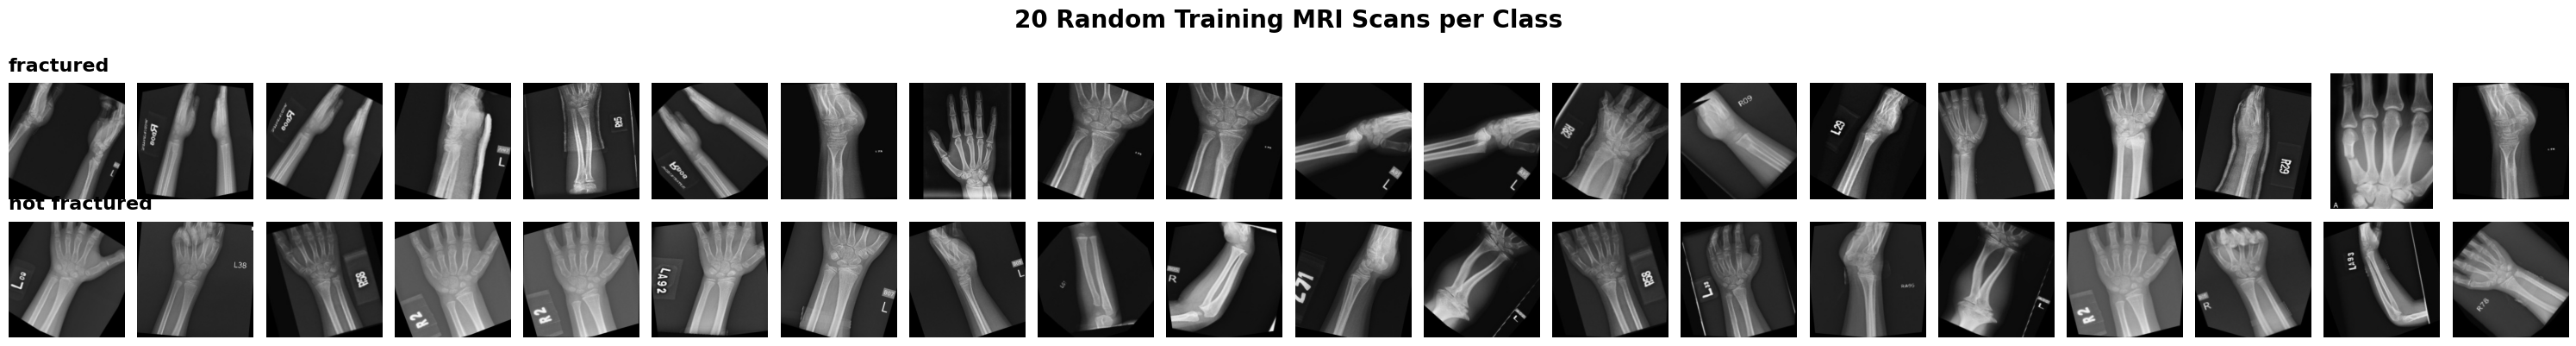

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Extract class names from your trained generator
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
images_per_class = 20

print(f"Found classes: {class_names}")
print("Plotting 20 random images from each class...")

# 2. Set up the matplotlib figure (Rows = Classes, Cols = 20)
# Making the figure wide enough to accommodate 20 images side-by-side
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(30, num_classes * 2))
fig.suptitle('20 Random Training MRI Scans per Class', fontsize=20, weight='bold', y=1.02)

# 3. Iterate through directories and plot
for i, class_name in enumerate(class_names):
    # Path to the specific class directory
    class_path = os.path.join(train_dir, class_name)

    # Get all image filenames in this class directory
    all_images = os.listdir(class_path)

    # Select random images (safeguarded in case a class has fewer than 20 images)
    selected_images = random.sample(all_images, min(images_per_class, len(all_images)))

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)

        # Read the image
        img = mpimg.imread(img_path)

        # Target the specific subplot axis
        ax = axes[i, j]

        # Display as grayscale (matching your generator settings)
        ax.imshow(img, cmap='grey')
        ax.axis('off') # Hide pixel axis numbers for a cleaner look

        # Add the class name above the very first image of each row
        if j == 0:
            ax.set_title(class_name, fontsize=16, weight='bold', loc='left', pad=10)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the pre-trained DenseNet121 model
# include_top=False removes the final classification layer so we can add our own
# weights='imagenet' uses the highly optimized pre-trained weights
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3) # Make sure your generator is set to 'rgb'!
)

# 2. Freeze the base model layers
# We don't want to destroy the pre-trained weights during initial training
for layer in base_model.layers:
    layer.trainable = False

# 3. Add our custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) # Condenses the feature maps
x = Dropout(0.5)(x) # Drops 50% of connections to prevent overfitting

# Note: 'num_classes' is from our previous visualization block.
# If you didn't run it, replace 'num_classes' with the actual integer (e.g., 4)
predictions = Dense(num_classes, activation='softmax')(x)

# 4. Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
# Using Adam optimizer with a slightly lower learning rate for stable transfer learning
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
model.summary()

Model compiled successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',      # Watch the validation loss
    patience=5,              # Wait 5 epochs without improvement before stopping
    restore_best_weights=True, # Automatically load the best weights when stopped
    verbose=1
)

checkpoint = ModelCheckpoint(
    # Saving directly back to your Hackathon Drive folder
    filepath='/content/drive/MyDrive/Vega Hackathon Dataset/best_xray_densenet.keras',
    monitor='val_accuracy',  # Save based on the highest validation accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # Drop learning rate to 20% of its current value
    patience=3,              # Wait 3 epochs before dropping
    min_lr=1e-6,             # Don't let the learning rate go below this
    verbose=1
)

callbacks_list = [early_stop, checkpoint, reduce_lr]

# 2. Train the Model
epochs = 30 # We can set this high because EarlyStopping will catch it if it finishes early

print("Starting the training process...")

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks_list,
    verbose=1
)

print("Training complete! The best model has been saved.")

Starting the training process...
Epoch 1/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5854 - loss: 1.0127
Epoch 1: val_accuracy improved from -inf to 0.75875, saving model to /content/drive/MyDrive/Vega Hackathon Dataset/best_xray_densenet.keras
289/289 ━━━━━━━━━━━━━━━━━━━━ 3339s 12s/step - accuracy: 0.5856 - loss: 1.0119 - val_accuracy: 0.7587 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 2/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7090 - loss: 0.5849
Epoch 2: val_accuracy improved from 0.75875 to 0.78408, saving model to /content/drive/MyDrive/Vega Hackathon Dataset/best_xray_densenet.keras
289/289 ━━━━━━━━━━━━━━━━━━━━ 95s 329ms/step - accuracy: 0.7090 - loss: 0.5849 - val_accuracy: 0.7841 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 3/30
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7168 - loss: 0.5549
Epoch 3: val_accuracy did not improve from 0.78408
289/289 ━━━━━━━━━━━━━━━━━━━━ 94s 324ms/step - accuracy: 0.7167 - loss: 0.5549 - val

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define the paths
train_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Fractures - X Ray/train'
test_dir = '/content/drive/MyDrive/Vega Hackathon Dataset/Fractures - X Ray/val'

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Create a model that maps the input image to the activations of the last conv layer
    # and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 4. Vector of shape (num_channels,), where each entry is the mean intensity of the gradient
    # over a specific feature map channel (Global Average Pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Multiply each channel in the feature map array by "how important this channel is"
    # then sum all channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalize the heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFile

# Fix for the truncated image error you had earlier
ImageFile.LOAD_TRUNCATED_IMAGES = True

def run_gradcam(img_path, model, last_conv_layer_name, target_size=(224, 224)):
    # 1. Preprocess the image
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize if your model expects [0,1]

    # 2. Setup Gradient Model
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 3. Record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 4. Compute Heatmap
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # 5. Superimpose Heatmap on Image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize heatmap and apply colormap
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    jet_heatmap = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB)

    # Blend original and heatmap
    superimposed_img = jet_heatmap * 0.4 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # 6. Display Results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {img_path.split('/')[-1]}")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap (Class: {pred_index})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# --- RUN IT HERE ---
# Change these values!
MY_IMG_PATH = '/content/drive/MyDrive/Vega Hackathon Dataset/Fractures - X Ray/val/fractured/000151594.png'
MY_LAST_CONV = 'conv2d_4' # Look at model.summary() to find this

run_gradcam(MY_IMG_PATH, model, MY_LAST_CONV)

NameError: name 'model' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFile

# Ensure truncated images don't crash the script
ImageFile.LOAD_TRUNCATED_IMAGES = True

def generate_gradcam(img_path, model, target_size=(128, 128)):
    # 1. Find the last conv layer automatically for DenseNet
    # In DenseNet121, it's usually the 'relu' layer right before the pooling
    last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Activation)][-1]

    # 2. Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    # DenseNet expects specific preprocessing (usually scaling to [0,1] or using its built-in util)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 3. Gradient Calculation
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 4. Normalize Heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # 5. Visualization
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    heatmap_img = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_img = np.uint8(255 * heatmap_img)
    jet_heatmap = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
    jet_heatmap = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB)

    superimposed_img = jet_heatmap * 0.4 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\n{img_path}")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap\nPredicted Class: {pred_index}")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# --- INTERACTIVE PROMPT ---
image_path = input("Please enter the full path to your image: ")
try:
    generate_gradcam(image_path, model)
except Exception as e:
    print(f"Error: {e}. Check if the path is correct and the image exists.")

Please enter the full path to your image:  /content/drive/MyDrive/56.png
Error: name 'model' is not defined. Check if the path is correct and the image exists.
